In [1]:
import pandas as pd
import sqlite3
from astropy.io import fits
import numpy as np
from scipy.optimize import fsolve
import glob
import matplotlib.pyplot as plt

In [2]:
def query_db(dbfile='data/ztf_metadata_latest.db',
             querystr=''):
    # Connect to the database (or create it if it doesn't exist)
    connection = sqlite3.connect(dbfile)
    cursor = connection.cursor()
    
    # Execute a SELECT query
    cursor.execute(querystr)
    
    # Fetch all the results
    rows = cursor.fetchall()
    
    # Process the data
    # for row in rows:
    #     print(row)
    
    # Close the connection
    connection.close()
    return rows

In [3]:
query = "SELECT name from sqlite_master WHERE type = 'table'"
res = query_db(querystr=query)
res

[('exposures',),
 ('fields',),
 ('fields_rtree',),
 ('fields_rtree_rowid',),
 ('fields_rtree_node',),
 ('fields_rtree_parent',),
 ('refimages',),
 ('deepimages',),
 ('fieldcorners',),
 ('fieldcorners_rtree',),
 ('fieldcorners_rtree_rowid',),
 ('fieldcorners_rtree_node',),
 ('fieldcorners_rtree_parent',)]

In [4]:
query = "SELECT name from sqlite_master WHERE type = 'table'"
res = query_db(querystr=query)
res

[('exposures',),
 ('fields',),
 ('fields_rtree',),
 ('fields_rtree_rowid',),
 ('fields_rtree_node',),
 ('fields_rtree_parent',),
 ('refimages',),
 ('deepimages',),
 ('fieldcorners',),
 ('fieldcorners_rtree',),
 ('fieldcorners_rtree_rowid',),
 ('fieldcorners_rtree_node',),
 ('fieldcorners_rtree_parent',)]

In [5]:
query = "SELECT * from sqlite_master WHERE name = 'exposures'"
res = query_db(querystr=query)
res[0][-1].split('\n')

['CREATE TABLE exposures (',
 '    expid integer NOT NULL PRIMARY KEY,                  -- Exposures ID, IPAC Primary Key for exposures (exposure name)',
 '    field integer NOT NULL,                              -- FITS-header keyword: FIELD, Field Number',
 '    filter text NOT NULL,                                -- FITS-header keyword: FID, Filter ID',
 '    obsdate timestamp without time zone NOT NULL,        -- FITS-header keyword: DATE-OBS',
 '    ra double precision NOT NULL,                        -- FITS-header keyword: RA, Right Ascension pointing',
 '    dec double precision NOT NULL,                       -- FITS-header keyword: DEC, Declination pointing',
 '    exptime real NOT NULL,                               -- FITS-header keyword: EXPTIME',
 '    airmass real NOT NULL,                               -- FITS-header keyword: AIRMASS',
 '    infobits integer DEFAULT 0,                 -- FITS-header keyword: INFOBITS, Defined by Palomar',
 '    dr integer,              

In [6]:
query = "PRAGMA table_info( exposures )"
res = query_db(querystr=query)
res

[(0, 'expid', 'INTEGER', 1, None, 1),
 (1, 'field', 'INTEGER', 1, None, 0),
 (2, 'filter', 'TEXT', 1, None, 0),
 (3, 'obsdate', 'timestamp without time zone', 1, None, 0),
 (4, 'ra', 'double precision', 1, None, 0),
 (5, 'dec', 'double precision', 1, None, 0),
 (6, 'exptime', 'REAL', 1, None, 0),
 (7, 'airmass', 'REAL', 1, None, 0),
 (8, 'infobits', 'INTEGER', 0, '0', 0),
 (9, 'dr', 'INTEGER', 0, None, 0),
 (10, 'numsci', 'INTEGER', 0, '0', 0),
 (11, 'numdiff', 'INTEGER', 0, '0', 0),
 (12, 'fwhm', 'REAL', 0, 'NULL', 0),
 (13, 'maglim', 'REAL', 0, 'NULL', 0),
 (14, 'scibckgnd', 'REAL', 0, 'NULL', 0),
 (15, 'ellip', 'REAL', 0, 'NULL', 0),
 (16, 'ellippa', 'REAL', 0, 'NULL', 0)]

In [9]:
query = "SELECT * from sqlite_master WHERE name = 'refimages'"
res = query_db(querystr=query)
res[0][-1].split('\n')

['CREATE TABLE refimages (',
 '    rfid bigint NOT NULL PRIMARY KEY,                    -- Reference ID, IPAC Primary key for reference images',
 '    rcid smallint NOT NULL,                              -- Readout Channel ID, see documentation for rcid layout',
 '    field integer NOT NULL,',
 '    filter smallint NOT NULL,                               -- Filter ID',
 '    created timestamp without time zone NOT NULL,',
 '    infobits integer DEFAULT 0 NOT NULL',
 ')']

In [7]:
query = "SELECT expid,infobits FROM exposures"
res = query_db(querystr=query)
res = pd.DataFrame(res,columns=["expid","infobits"])
res.infobits.unique()

array([0])

In [264]:
query = "SELECT ra,dec,airmass,exptime,filter,obsdate FROM exposures where expid=204721950"
res = query_db(querystr=query)
res

[(231.133166666667, -9.85, 2.252, 30.0, 'g', '2022-08-10 05:16:05.142')]

In [289]:
query = """SELECT expid,scibckgnd,maglim,fwhm FROM exposures 
           WHERE scibckgnd> (SELECT AVG(scibckgnd) FROM exposures) - 0.001
           AND scibckgnd< (SELECT AVG(scibckgnd) FROM exposures) + 0.001"""
res = query_db(querystr=query)

In [290]:
res

[(70227210, 189.043, 20.46365, 2.253915),
 (73722521, 189.0445, 20.69965, 2.186535),
 (147223675, 189.043, 20.0089, 3.3230000000000004),
 (196747671, 189.043, 19.87645, 2.1850449999999997),
 (199634589, 189.0445, 20.492150000000002, 2.570145)]

In [202]:
# mag = -2.5log10(flux) + zp
# flux = 10^-0.4(mag-zp)

In [203]:
# snr = flux/fluxerr
# fluxerr = sqrt(flux + sky*npix*Gain + readnoise**2*nexposure*npix + darkcurrent*npix*exptime*nexposure + sigma_calib**2) 
# 5 = flux/fluxerr
# 25 = flux**2/(flux + sky*npix*Gain + readnoise**2*nexposure*npix + darkcurrent*npix*exptime*nexposure) 
# flux**2 - 25*flux -25*( sky*npix*Gain + readnoise**2*nexposure*npix +darkcurrent*npix*exptime*nexposure )= 0
# flux = 12.5 + 0.5*sqrt(625 +100( sky*npix*Gain + readnoise**2*nexposure*npix + darkcurrent*npix*exptime*nexposure) )
# zp = 2.5log(flux) + maglim

In [204]:
def fluxeq(flux,sky=None,Gain=None,readnoise=None,nexposure=1,fwhm=None, darkcurrent=None,exptime=None):
    npix = 2.266*fwhm**2 #=4*pi*sigma**2=pi/2/ln2 * FWHM**2
    y = flux**2 - 25*flux -25*(sky*npix*Gain + readnoise**2*nexposure*npix + darkcurrent*npix*exptime*nexposure)
    return y

In [205]:
fwhm = res[0][12]
maglim = res[0][13]
sky = res[0][14]
exptime = res[0][6]
fwhm,maglim,sky,exptime

(3.382285, 19.6376, 333.228, 30.0)

In [220]:
#from FITS file header
ZPAVG = 26.137739 #/ Mag zero point from average of mag diffs [mag]
MAGZP = 26.161633 #/ Magnitude zero point for PSF-photometry [mag]  
MAGLIM = 19.81
GAIN = 6.2 #/ Gain e-/adu                                    
READNOI = 10. #/ Read noise e-                                  
DARKCUR = 1. #/ Dark current e-/s @ 150 K  
EXPID = 44825324
AIRMASS = 1.63 #/ Airmass (Hardie)     
FILTERID=  1 #/ Filter ID code                                 
FILTER = 'ZTF g   '  #/ Filter name     
SEEING = 3.305 #/ seeing FWHM [pixels] 

In [221]:
root = fsolve(lambda x: fluxeq(x,sky=sky,Gain=GAIN,readnoise=READNOI,fwhm=fwhm,darkcurrent=DARKCUR,exptime=exptime), [100])

In [222]:
zp = 2.5*np.log10(root/GAIN) + maglim
zp

array([25.35956619])

In [249]:
def cal_zp(exposure_id, GAIN=6.2,READNOI=10.,DARKCUR=1.,maglim=None,fwhm=None):
    query = f"SELECT * FROM exposures where expid={exposure_id}"
    res = query_db(querystr=query)
    if fwhm is None:
        fwhm = res[0][12]
    if maglim is None:
        maglim = res[0][13]
    sky = res[0][14]
    exptime = res[0][6]
    root = fsolve(lambda x: fluxeq(x,sky=sky,Gain=GAIN,readnoise=READNOI,
                                   fwhm=fwhm,darkcurrent=DARKCUR,exptime=exptime), [500])
    zp = 2.5*np.log10(root/GAIN) + maglim

    npix = 2.266*fwhm**2
    root2 = 12.5 + 2.5 * np.sqrt(25. + 4.*(sky*npix*GAIN + READNOI**2*npix + DARKCUR*npix*exptime))
    zp2 = 2.5*np.log10(root2/GAIN) + maglim

    print("maglim,fwhm,sky:",maglim,fwhm,sky,exposure_id)
    print(zp,zp2)
    return zp[0]

In [250]:
def get_single_fits_header(fname):
    hdu = fits.open(fname)
    h = hdu[0].header 
    colname = ['GAIN','READNOI','DARKCUR','MAGLIM','SEEING','EXPID','MAGZP','ZPAVG','OBSMJD']
    coldict = {}
    for col in colname:
        coldict[col]=h[col]
    return coldict

In [251]:
dlist = []
for f in glob.glob('ztf_images/*.fits'):
    dlist.append(get_single_fits_header(f))
header_info = pd.DataFrame(dlist)

In [252]:
header_info

,GAIN,READNOI,DARKCUR,MAGLIM,SEEING,EXPID,MAGZP,ZPAVG,OBSMJD
0,6.1,9.1,1.0,21.69,1.716,191636034,26.111347,26.180340,59670.360347
1,6.1,9.1,1.0,20.25,1.727,131915505,25.434052,25.509272,59073.155058
2,6.1,9.1,1.0,21.28,1.893,109516991,26.159958,26.235765,58849.169919
3,6.1,9.1,1.0,21.20,2.109,124116407,26.193658,26.158520,58995.164074
4,6.1,9.1,1.0,21.00,1.526,109507708,26.156597,26.213345,58849.077083
5,6.1,9.1,1.0,21.49,3.670,111225071,28.695676,28.645560,58866.250718
6,6.1,9.1,1.0,20.86,3.514,109508552,26.307774,26.212914,58849.085521
7,6.1,9.1,1.0,20.96,2.079,131917035,26.129401,26.201074,59073.170359
8,6.1,9.1,1.0,19.56,2.372,187110479,26.098978,26.195360,59625.104792
9,6.1,9.1,1.0,20.98,1.538,109507943,26.165938,26.219344,58849.079433


In [253]:
zplist = []
for i,row in header_info.iterrows():
    zplist.append(cal_zp(row['EXPID'],
                         maglim=row['MAGLIM'],fwhm=None))
zplist

maglim,fwhm,sky: 21.69 1.906275 250.272 191636034.0
[26.65623029] 26.656230294073413
maglim,fwhm,sky: 20.25 1.45972 216.27550000000002 131915505.0
[24.86288038] 24.86288038216208
maglim,fwhm,sky: 21.28 1.855265 222.126 109516991.0
[26.15927506] 26.159275055597682
maglim,fwhm,sky: 21.2 1.9122249999999998 93.63300000000001 124116407.0
[25.71421155] 25.714211554453033
maglim,fwhm,sky: 21.0 1.63771 224.9 109507708.0
[25.75317666] 25.753176661019243
maglim,fwhm,sky: 21.49 3.901435 1258.4850000000001 111225071.0
[28.07612457] 28.07612456956872
maglim,fwhm,sky: 20.86 2.04033 120.621 109508552.0
[25.55387145] 25.553871445783006
maglim,fwhm,sky: 20.96 2.0795500000000002 177.1635 131917035.0
[25.85186236] 25.851862360533183
maglim,fwhm,sky: 19.56 2.5854299999999997 151.01049999999998 187110479.0
[24.60804116] 24.60804115814153
maglim,fwhm,sky: 20.98 1.49583 291.742 109507943.0
[25.76451673] 25.7645167252947
maglim,fwhm,sky: 19.65 2.937265 84.12025 113109947.0
[24.57185772] 24.571857716113755
mag

[26.656230294073413,
 24.862880382162082,
 26.159275055597682,
 25.714211554453033,
 25.753176661019243,
 28.07612456956872,
 25.553871445783006,
 25.851862360533183,
 24.60804115814153,
 25.7645167252947,
 24.57185771611375,
 26.06615957016011,
 25.824211554453033,
 26.068280228016448,
 27.56423417241887,
 24.626897157143844,
 25.745836389391854,
 24.871587487318095,
 24.774294571400723,
 25.723049869536815]

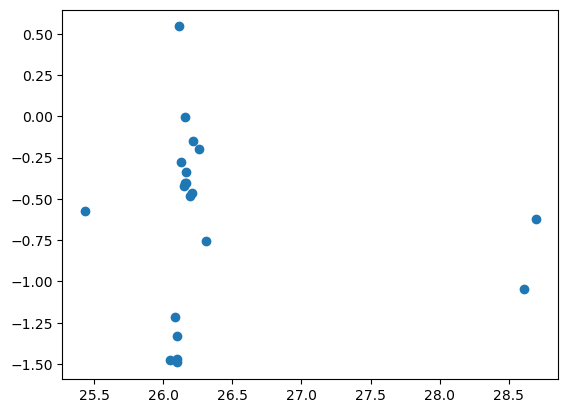

In [239]:
plt.plot(header_info['MAGZP'].values,np.array(zplist)-header_info['MAGZP'].values,'o')
